# U-Net Segmentation on Mapping Challenge

The Mapping Challenge Dataset for crowdAI Mapping Challenge contains thousands of images
of human-populated areas, extracted from satellite fotage over different places. Instance-level segmentation marks are available for each image, as illustrated in the figure below.

We use the `U-Net` (`EfficientNetB4` backbone) to segment buildings.

![Examples in the Mapping Challenge Dataset, and their respective segmentation maps](https://raw.githubusercontent.com/lucasdavid/lucasdavid.github.io/master/assets/ml/segmentation/mapping-challenge/examples.png)

References:

  - Mapping Challenge Dataset. Kaggle. https://www.kaggle.com/kmader/synthetic-word-ocr
  - CrowdAI Mapping Challenge. CrowdAI. https://www.crowdai.org/challenges/mapping-challenge
  - Falk, T., Mai, D., Bensch, R., Çiçek, Ö., Abdulkadir, A., Marrakchi, Y., Böhm, A., Deubner, J., Jäckel, Z., Seiwald, K. and Dovzhenko, A., 2019. U-Net: deep learning for cell counting, detection, and morphometry. Nature methods, 16(1), pp.67-70. https://arxiv.org/abs/1505.04597
  - Tan, M. and Le, Q., 2019, May. Efficientnet: Rethinking model scaling for convolutional neural networks. In International Conference on Machine Learning (pp. 6105-6114). PMLR. https://arxiv.org/abs/1905.11946
  - Jadon, S., 2020, October. A survey of loss functions for semantic segmentation. In 2020 IEEE Conference on Computational Intelligence in Bioinformatics and Computational Biology (CIBCB) (pp. 1-7). IEEE. https://arxiv.org/abs/2006.14822

In [1]:
%load_ext tensorboard

In [2]:
N = 8

# Data params
BUFFER_SIZE = 100000
IMAGE_SIZE = (300, 300)
OUTPUT_CHANNELS = 1
BATCH_SIZE = 64
INPUT_SHAPE = (BATCH_SIZE, *IMAGE_SIZE, 3)

# Split params
TRAIN_SIZE = 0.7
VALID_SIZE = 0.3
SEED = 108241

# Training params
TRAINING = False
EPOCHS = 200
EARLY_STOPPING_PATIENCE = EPOCHS // 3
REDUCE_LR_ON_PLATEAU_PATIENCE = max(5, EPOCHS // 10)

# Loss params
CL_CE_W = 0.05
LR_INITIAL = .005
LR_FIRST_DECAY_STEPS = 50  # None for constant learning-rate

LOGS = '/content/drive/My Drive/Colab Notebooks/cs-no/3.segmentation/logs/mapping-challenge/uefficientnet'

## Setup

### System Imports, Setups and Utils

In [3]:
! mkdir -p ~/.kaggle
! cp '/content/drive/MyDrive/secrets/kaggle.json' ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

! pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
! pip install -q -U albumentations

In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

import math, os, json
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import albumentations as A
from skimage import color, io
from pycocotools.coco import COCO

In [5]:
sns.set()

In [6]:
rs = np.random.RandomState(SEED)
C = plt.get_cmap('tab10').colors

In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [8]:
#@title

# We define cosine decay restarts here because it's only available
# in tensorflow nightly build at this time.
#
class CosineDecayRestarts(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(
      self,
      initial_learning_rate,
      first_decay_steps,
      t_mul=2.0,
      m_mul=1.0,
      alpha=1e-6,
      name=None):
    super(CosineDecayRestarts, self).__init__()

    self.initial_learning_rate = initial_learning_rate
    self.first_decay_steps = first_decay_steps
    self._t_mul = t_mul
    self._m_mul = m_mul
    self.alpha = alpha
    self.name = name

  def __call__(self, step):
    with tf.name_scope(self.name or "SGDRDecay") as name:
      initial_learning_rate = tf.convert_to_tensor(self.initial_learning_rate, name="initial_learning_rate")
      dtype = initial_learning_rate.dtype
      first_decay_steps = tf.cast(self.first_decay_steps, dtype)
      alpha = tf.cast(self.alpha, dtype)
      t_mul = tf.cast(self._t_mul, dtype)
      m_mul = tf.cast(self._m_mul, dtype)

      global_step_recomp = tf.cast(step, dtype)
      completed_fraction = global_step_recomp / first_decay_steps

      def compute_step(completed_fraction, geometric=False):
        """Helper for `cond` operation."""
        if geometric:
          i_restart = tf.math.floor(
              tf.math.log(1.0 - completed_fraction * (1.0 - t_mul)) /
              tf.math.log(t_mul))

          sum_r = (1.0 - t_mul**i_restart) / (1.0 - t_mul)
          completed_fraction = (completed_fraction - sum_r) / t_mul**i_restart

        else:
          i_restart = tf.math.floor(completed_fraction)
          completed_fraction -= i_restart

        return i_restart, completed_fraction

      i_restart, completed_fraction = tf.cond(
          tf.math.equal(t_mul, 1.0),
          lambda: compute_step(completed_fraction, geometric=False),
          lambda: compute_step(completed_fraction, geometric=True))

      m_fac = m_mul**i_restart
      cosine_decayed = 0.5 * m_fac * (1.0 + tf.math.cos(
          tf.constant(math.pi) * completed_fraction))
      decayed = (1 - alpha) * cosine_decayed + alpha

      return tf.math.multiply(initial_learning_rate, decayed, name=name)

  def get_config(self):
    return {
        "initial_learning_rate": self.initial_learning_rate,
        "first_decay_steps": self.first_decay_steps,
        "t_mul": self._t_mul,
        "m_mul": self._m_mul,
        "alpha": self.alpha,
        "name": self.name
    }

## Learning Rate Behavior over Time

In [9]:
LR = (CosineDecayRestarts(LR_INITIAL, LR_FIRST_DECAY_STEPS, t_mul=1., m_mul=.7, alpha=0.1)
      if LR_FIRST_DECAY_STEPS
      else LR_INITIAL)

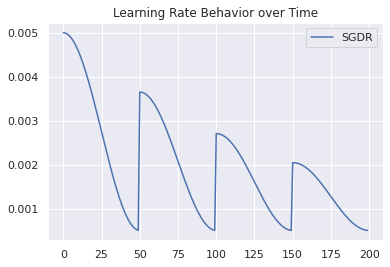

In [10]:
#@title

steps = tf.range(EPOCHS)
sns.lineplot(x=steps,
             y=LR(steps) if LR_FIRST_DECAY_STEPS else [LR_INITIAL] * EPOCHS,
             label='SGDR' if LR_FIRST_DECAY_STEPS else 'constant')
plt.title('Learning Rate Behavior over Time');

## Dataset

In [11]:
map_base_dir = '../input/'
map_img_dir = '../input/train/images/'
annot_path = os.path.join(map_base_dir, 'annotation-small.json')

In [12]:
%%bash

if ! [ -f /input/annotation-small.json ]; then
    kaggle datasets download kmader/synthetic-word-ocr -p ../input
    unzip -q ../input/synthetic-word-ocr.zip -d ../input
    rm ../input/synthetic-word-ocr.zip
fi

In [13]:
coco = COCO(str(annot_path))
cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)
img_ids = coco.getImgIds(catIds=cat_ids)

loading annotations into memory...
Done (t=0.89s)
creating index...
index created!


In [14]:
def prepare(sample_ids, augment=False):
    load_fn = load_and_augment if augment else load_image_and_mask_float32

    return (tf.data.Dataset.from_tensor_slices(sample_ids)
            .map(lambda _id: tf.numpy_function(func=load_fn,
                                               inp=[_id],
                                               Tout=(tf.float32, tf.float32)),
                 num_parallel_calls=tf.data.AUTOTUNE)
            .shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE)
            .prefetch(tf.data.AUTOTUNE))

def load_and_augment(image_id):
    image, mask = load_image_and_mask(image_id)
    aug_data = transforms(image=image, mask=mask)
    
    return (aug_data['image'].astype(np.float32),
            aug_data['mask'].astype(np.float32))

def load_image_and_mask(img_id):
    info = coco.loadImgs(int(img_id))[0]
    file = os.path.join(map_img_dir, info['file_name'])
    image = io.imread(file)

    mask = get_mask(info)

    return image, mask

def load_image_and_mask_float32(img_id):
    image, mask = load_image_and_mask(img_id)

    return image.astype(np.float32), mask.astype(np.float32)


def get_mask(info):
    img_shape = (info['width'], info['height'], len(cat_ids))
    
    ann_ids = coco.getAnnIds(imgIds=info['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(ann_ids)

    masks = np.zeros(img_shape)
    for idx, cat_id in enumerate(cat_ids):
        mask = np.zeros(img_shape[:2], dtype=np.float32)
        for ann in anns:
            if cat_id == ann['category_id']:
                mask = np.maximum(mask, coco.annToMask(ann))
        masks[:, :, idx] = mask
    return masks


def visualize(image_id):
    img = coco.loadImgs(img_ids[image_id])[0]
    I = io.imread(os.path.join(map_img_dir, img['file_name']))

    plt.imshow(I)
    plt.axis('off')

    annIds = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
    anns = coco.loadAnns(annIds)
    coco.showAnns(anns)

### Training, validation and test splits

In [15]:
train_ids, test_ids = train_test_split(img_ids, train_size=TRAIN_SIZE, random_state=rs)
train_ids, valid_ids = train_test_split(train_ids, test_size=VALID_SIZE, random_state=rs)

print('Training samples:', len(train_ids))
print('Validation samples:', len(valid_ids))
print('Test samples:', len(test_ids))

Training samples: 4099
Validation samples: 1757
Test samples: 2510


### Augmentation Policy

In [16]:
transforms = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(scale_limit=0.25, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

    # A.PadIfNeeded(min_height=height, min_width=width, always_apply=True, border_mode=0),
    # A.RandomCrop(height=height, width=width, always_apply=True),

    A.IAAAdditiveGaussianNoise(p=0.2),
    A.IAAPerspective(p=0.5),
    A.OneOf([
        A.CLAHE(p=1.),
        A.RandomBrightness(p=1.),
        A.RandomGamma(p=1.),
    ], p=0.9),

    A.OneOf([
        A.IAASharpen(p=1),
        A.Blur(blur_limit=3, p=1),
        A.MotionBlur(blur_limit=3, p=1),
    ], p=0.9),
    A.OneOf([
        A.RandomContrast(p=1),
        A.HueSaturationValue(p=1)
    ], p=0.9)
])

In [17]:
train_data = prepare(train_ids, augment=True)
valid_data = prepare(valid_ids)
test_data = prepare(test_ids)

## Network

In [18]:
DOWNSTACK_LAYERS = [
   'block2a_expand_activation',
   'block3a_expand_activation',
   'block4a_expand_activation',
   'block6a_expand_activation',
   'top_activation']

UPSTACK_LAYERS = [
    dict(filters=1024, size=3, dropout=.2),
    dict(filters=512, size=3, dropout=.2),
    dict(filters=256, size=3, dropout=.2),
    dict(filters=128, size=3, dropout=.2),
]

In [19]:
from tensorflow.keras import applications, Model, Input

base_model = applications.EfficientNetB4(input_shape=[300, 300, 3],
                                         include_top=False,
                                         weights='imagenet')

In [20]:
# Use the activations of these layers
layers = [base_model.get_layer(name).output for name in DOWNSTACK_LAYERS]
down_stack = Model(inputs=base_model.input, outputs=layers, name='downstack')
down_stack.trainable = False

In [21]:
print('Selected downstack layers:')

for l in DOWNSTACK_LAYERS:
    print(' ', l, base_model.get_layer(l).output.shape)

Selected downstack layers:
  block2a_expand_activation (None, 150, 150, 144)
  block3a_expand_activation (None, 75, 75, 192)
  block4a_expand_activation (None, 38, 38, 336)
  block6a_expand_activation (None, 19, 19, 960)
  top_activation (None, 10, 10, 1792)


In [22]:
from tensorflow.keras.layers import (Layer, Conv2DTranspose, Dropout, Activation,
                                     BatchNormalization, ZeroPadding2D, Cropping2D,
                                     Concatenate)

class UpSample(Layer):
    def __init__(self,
                 filters,
                 size=3,
                 strides=2,
                 norm='batch',
                 padding='same',
                 dropout=0.,
                 activation='swish',
                 *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.filters = filters
        self.size = size
        self.conv2d_tr = Conv2DTranspose(
            filters, size, strides=strides,
            padding=padding,
            kernel_initializer=tf.random_normal_initializer(0., 0.02),
            use_bias=False)
        self.norm = norm
        self.norm_fn = (BatchNormalization() if norm == 'batch' else None)
        self.dropout = dropout
        self.dropout_fn = (Dropout(dropout) if dropout else None)
        self.activation_fn = Activation(activation)

    def call(self, x):
        y = self.conv2d_tr(x)
        if self.norm: y = self.norm_fn(y)
        if self.dropout: y = self.dropout_fn(y)
        
        return self.activation_fn(y)

In [23]:
def size2d(x): return x.shape[1:3]
def size3d(x): return x.shape[1:]

def unet_model(
        downstack_layers,
        upstack_layers,
        image_size,
        output_channels):
    inputs = Input(shape=[*image_size, 3], name='images')
    outputs = down_stack(inputs)
    x = outputs[-1]
    skips = reversed(outputs[:-1])

    print(f'last :- {size2d(x)}')

    for ix, (l, args, skip) in enumerate(zip(downstack_layers, upstack_layers, skips)):
        y = UpSample(**args, name=f'{l}/upsampling')(x)

        if size2d(y) != size2d(skip):
            y = Cropping2D(((0, 1), (0, 1)), name=f'{l}/crop')(y)

        z = Concatenate(name=f'{l}/concat')([y, skip])

        print(f'{l} {args}\n  {size3d(z)} :- {size3d(y)}, {size3d(skip)}')

        x = z

    x = Conv2DTranspose(output_channels, 3,
                        strides=2,
                        padding='same',
                        name='segments')(x)
    return Model(inputs=inputs, outputs=x, name='unet')

In [24]:
u = unet_model(
    DOWNSTACK_LAYERS,
    UPSTACK_LAYERS,
    IMAGE_SIZE,
    OUTPUT_CHANNELS)

last :- (10, 10)
block2a_expand_activation {'filters': 1024, 'size': 3, 'dropout': 0.2}
  (19, 19, 1984) :- (19, 19, 1024), (19, 19, 960)
block3a_expand_activation {'filters': 512, 'size': 3, 'dropout': 0.2}
  (38, 38, 848) :- (38, 38, 512), (38, 38, 336)
block4a_expand_activation {'filters': 256, 'size': 3, 'dropout': 0.2}
  (75, 75, 448) :- (75, 75, 256), (75, 75, 192)
block6a_expand_activation {'filters': 128, 'size': 3, 'dropout': 0.2}
  (150, 150, 272) :- (150, 150, 128), (150, 150, 144)


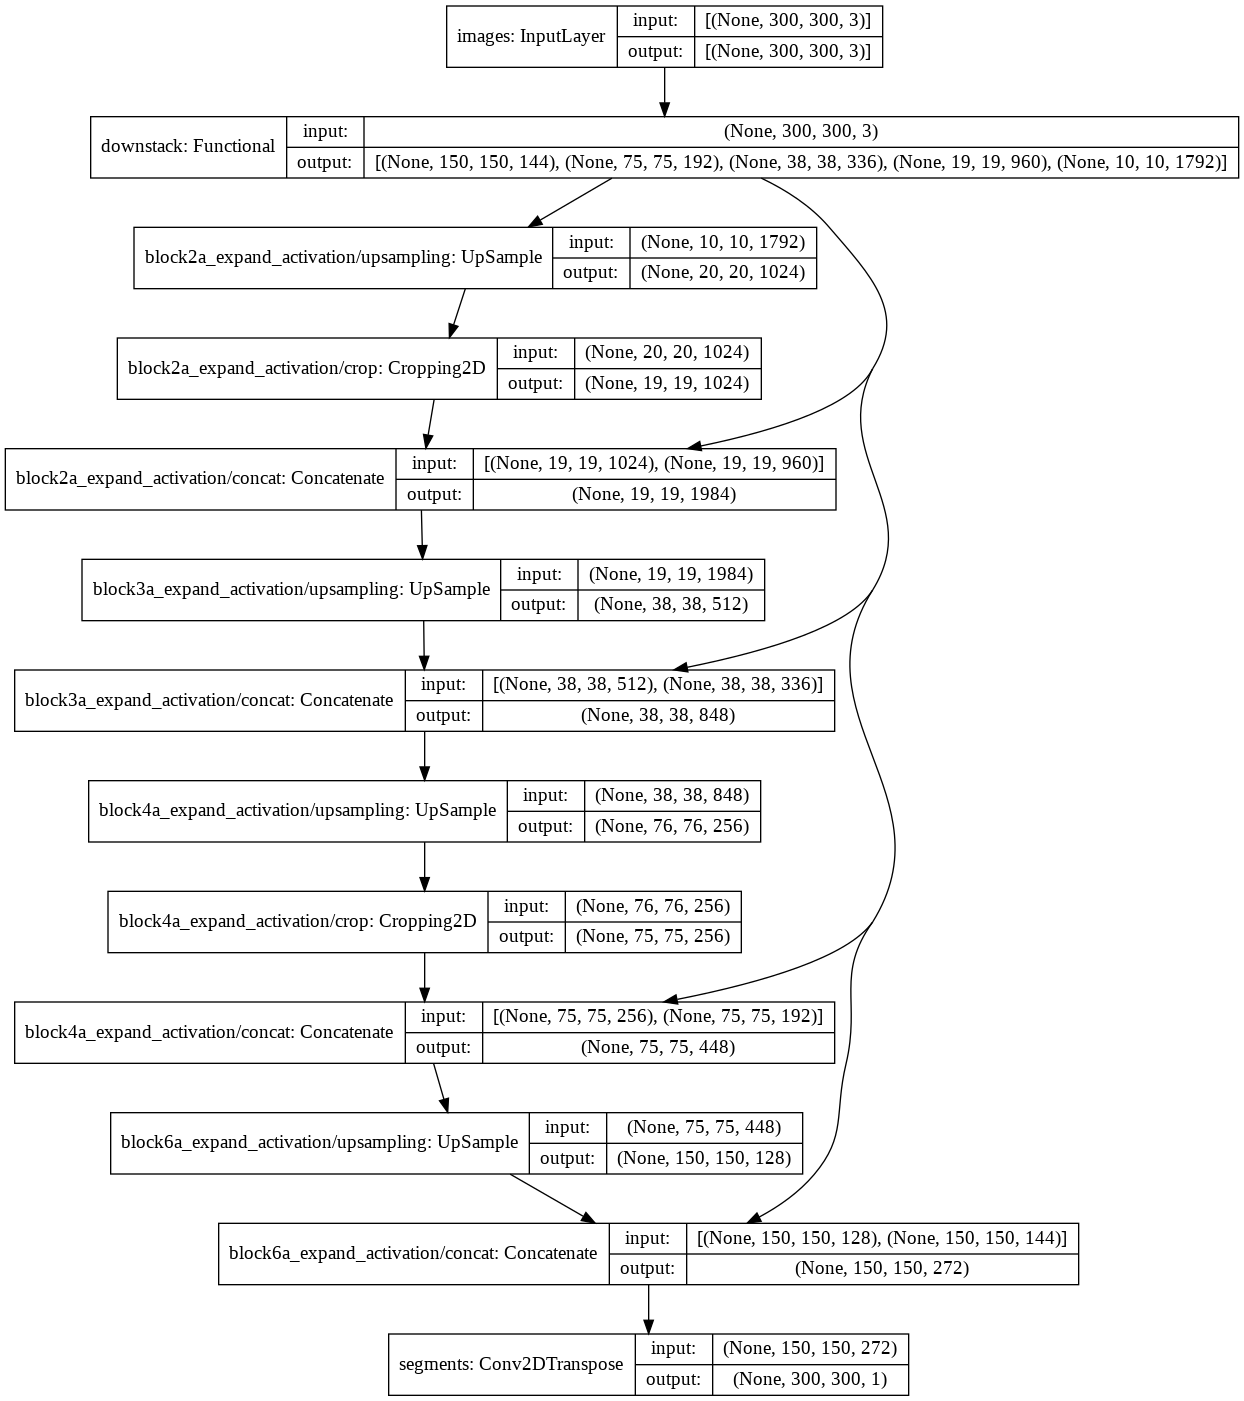

In [25]:
tf.keras.utils.plot_model(u, show_shapes=True)

### Explanation for `Cropping2D` Corrections in Network's Definition


During `EfficientNetB4` forward pass, downsampling is performed by feeding a `(B, H, W, C)` input signal to `ZeroPadding2D(1)` and `DepthwiseConv2D(K, 3, strides=2, padding='valid')` layers, which produces a `(B, H//2 + 1, W//2 + 1, C)` output signal. For example:
```r
  [1 2 3 4 5]
       |
[0 1 2 3 4 5 0]
      (*)
[a b c]
    [a b c]
        [a b c]
       |
    [x y z]
```

When upstacking the signal, `Conv2DTranspose(C, 3, strides=2, padding='same')` is applied, which will generate a signal of shape `(B, 2*(H//2 + 1), 2*(W//2 + 1), C)`:

```r
    [x y z]
      (*)T
  [a b c]
   [a b c]
    [a b c]
     [a b c]
      [a b c]
       [a b c]
        [a b c]
        |
  [1 2 3 4 5 6]
```
In case this is not clear, we are taking 1/2-sized steps in the diagram above because `strides=2`.

The output signal contains exactly one more pixel than its downstack couterpart.
The easiest solution here (which was done in the code) is to simply discard either pixel `1` or `6`:
```r
 [1 2 3 4 5 6]
      |
 [1 2 3 4 5]
```

Is this a good idea? I don't know; but I'm getting 91% binary accuracy, so...

**Idea:** instead of cropping, we could apply a second conv (e.g. gaussian kernel), which would sub-divide the information loss amongst all pixels.
```r
 [1 2 3 4 5 6]
      (*)
 [a b]
   [a b]
     [a b]
       [a b]
         [a b]
  [x y z w k]
```

### Metrics and Loss Functions

In [26]:
def dice_coef(y_true, y_pred, s=1):
    y_pred = tf.nn.sigmoid(y_pred)

    i = tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
    u = tf.reduce_sum(y_true, axis=(1,2,3)) + tf.reduce_sum(y_pred, axis=(1,2,3))

    return tf.reduce_mean((2.*i + s)/(u + s), axis=0)

def combo_loss(in_gt, in_pred):
    return CL_CE_W * tf.losses.binary_crossentropy(in_gt, in_pred, from_logits=True) - (1-CL_CE_W) * dice_coef(in_gt, in_pred)

def spatial_true_positive_rate(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0, y_true.dtype)  # from logits
    return tf.reduce_sum(y_true * y_pred) / tf.reduce_sum(y_true)

In [27]:
u.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
          loss=combo_loss,
          metrics=[
              tf.metrics.BinaryAccuracy(threshold=0.),  # from logits
              dice_coef,
              spatial_true_positive_rate,
          ])

## Training

In [28]:
if TRAINING:
    # Fails if exist. We probably don't want to overwrite tensorboard logs right?
    # Use LOGS + '/str(int(time()))' or initial_epoch=LAST_EPOCH if you want to force this.
    os.makedirs(LOGS)

    try:
        u.fit(
            train_data,
            epochs=EPOCHS,
            validation_data=valid_data,
            callbacks=[
                tf.keras.callbacks.TerminateOnNaN(),
                tf.keras.callbacks.EarlyStopping(
                    patience=EARLY_STOPPING_PATIENCE,
                    verbose=1),
                tf.keras.callbacks.TensorBoard(
                    log_dir=LOGS,
                    histogram_freq=10,
                    write_graph=False,
                    write_images=True),
                tf.keras.callbacks.ModelCheckpoint(
                    LOGS + '/weights.h5',
                    save_weights_only=True,
                    save_best_only=True,
                    verbose=1),
                tf.keras.callbacks.ReduceLROnPlateau(
                    patience=REDUCE_LR_ON_PLATEAU_PATIENCE,
                    verbose=1),
            ])

    except KeyboardInterrupt: print('\ninterrupted')
    else: print('done')

## Testing

In [30]:
u.load_weights(LOGS + '/weights.h5')

In [31]:
report = pd.DataFrame(
    [u.evaluate(train_data, verbose=0),
     u.evaluate(valid_data, verbose=0),
     u.evaluate(test_data, verbose=0)],
    columns=u.metrics_names,
    index=['training', 'validation', 'testing']).T

report

,training,validation,testing
loss,-0.734217,-0.758882,-0.757366
binary_accuracy,0.925547,0.933610,0.934262
dice_coef,0.790973,0.816184,0.814437
spatial_true_positive_rate,0.831747,0.847645,0.854308


### Visualizing Predictions from The Testing Set

In [32]:
#@title

def plot_images_and_segments(x, y, p):
    titles=['satellite image', 'ground truth', 'predictions']

    plt.figure(figsize=(9, 16))

    for i in range(N):
        imgs = (tf.cast(x[i], tf.int16), y[i, ..., 0], p[i, ..., 0])

        for j, img in enumerate(imgs):
            plt.subplot(N, 4, i * 4 + j + 1)
            plt.imshow(img)
            if not i: plt.title(titles[j])
            plt.axis('off')

    plt.tight_layout()

In [33]:
x, y = next(iter(test_data.take(1)))

p = u.predict(x)
p = tf.cast(p > 0, tf.float32)

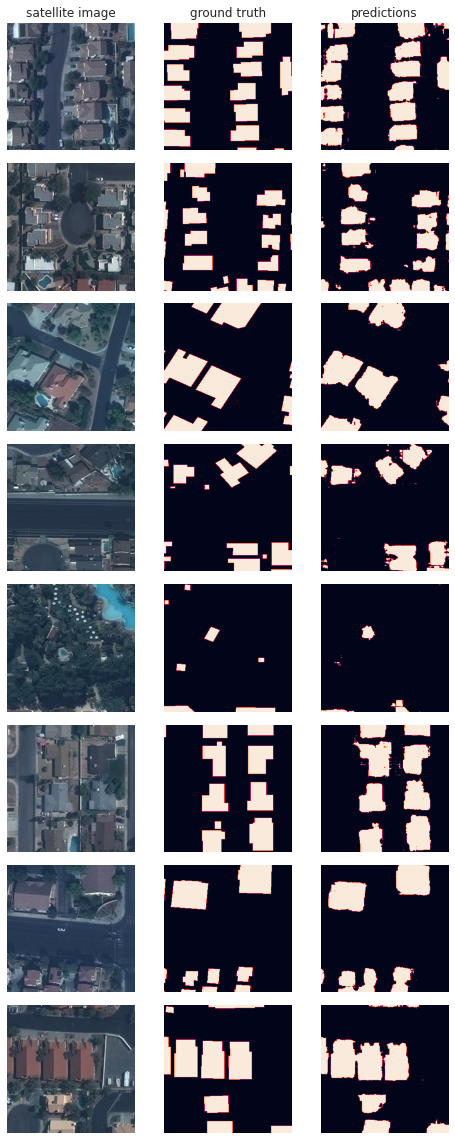

In [34]:
plot_images_and_segments(x, y, p)